# Overview
This project is to scrape data from [a number of a16z-backed companies](https://www.linkedin.com/posts/jordanmazer_these-35-andreessen-horowitz-backed-companies-activity-7320077608052764672-A2Kg/?utm_source=share&utm_medium=member_desktop&rcm=ACoAACxXoykB8aL2eDtVoQzAVrRBauNOqQkoC4w) and measure which skills are currently in high demand.

# TODO
- [X] Freeze URL list
- [X] Resolve redirects & detect ATS type
- [X] Prototype one company end-to-end
- [X] Design skill vocabulary v0
- [X] Evaluate extraction on 10 random postings
- [ ] Scale to full list
- [X] Plot & polish

In [1]:
pip install -r requirements.txt


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# imports
import csv
import json
import pathlib
import requests
import re
import textwrap
import time
import traceback
import pandas as pd
import importlib
import matplotlib.pyplot as plt
from pathlib import Path
from bs4 import BeautifulSoup
from html import unescape
from urllib.parse import urlparse
from collections import Counter
import collectors.greenhouse as gh
import collectors.lever      as lv
import collectors.ashby      as ab

In [3]:
PROJECT_ROOT = Path().resolve()

In [4]:
# router function

# pre-compile patterns for speed & clarity
ATS_PATTERNS = {
    "ashby":      re.compile(r"jobs\.ashbyhq\.com/[^/]+", re.I),
    "greenhouse": re.compile(r"boards\.greenhouse\.io/[^/]+", re.I),
    "lever":      re.compile(r"jobs\.lever\.co/[^/]+", re.I),
    "workable":   re.compile(r"(apply|careers)\.workable\.com/[^/]+", re.I),
}

def detect_ats(url: str) -> str:
    """
    Return a string label for the ATS type based on the input URL.
    Falls back to 'html' when no pattern matches.
    """
    netloc_and_path = urlparse(url).netloc + urlparse(url).path
    for ats, pattern in ATS_PATTERNS.items():
        if pattern.search(netloc_and_path):
            return ats
    return "html"          # default / unknown

In [5]:
# Establish paths
RAW_DIR    = Path("data/raw");     RAW_DIR.mkdir(parents=True, exist_ok=True)
BRONZE_DIR = Path("data/bronze");  BRONZE_DIR.mkdir(parents=True, exist_ok=True)
SILVER_DIR = Path("data/silver");  SILVER_DIR.mkdir(parents=True, exist_ok=True)

In [6]:
# ---------- helpers ----------
def detect_ats(url: str) -> str:
    if "boards.greenhouse.io" in url:
        return "greenhouse"
    if "lever.co" in url:
        return "lever"
    if "ashbyhq.com" in url:
        return "ashby"
    return "unknown"

def html_to_text(html: str) -> str:
    soup = BeautifulSoup(unescape(html), "html.parser")
    for t in soup(["style", "script"]):
        t.decompose()
    return soup.get_text(" ", strip=True)

In [7]:
# DATA SCRAPING

In [8]:
def run_board(url: str):
    ats = detect_ats(url)
    if ats == "unknown":
        print("SKIP  – no collector:", url)
        return

    # --- choose collector ---
    if ats == "greenhouse": get_postings = gh.get_postings
    elif ats == "lever":    get_postings = lv.get_postings
    else:                   get_postings = ab.get_postings

    try:
        df = get_postings(url)          # <- returns 6-col DataFrame (bronze)    
    except Exception as e:
        print("ERROR –", url, "→", e.__class__.__name__)
        traceback.print_exc(limit=1)
        return
    
    token = gh._extract_board_token(url)  if ats=="greenhouse" else \
            lv._extract_board_token(url)  if ats=="lever"      else \
            ab._extract_board_token(url)

    # ------------- bronze -------------
    bronze_path = BRONZE_DIR / f"{ats}_{token}.parquet"
    df.to_parquet(bronze_path, index=False)
    print("Saved BRONZE →", bronze_path.name, df.shape)

    # ------------ silver ------------
    if "description" in df.columns:
        pass                                  # already plain text
    elif "description_html" in df.columns:
        df["description"] = df["description_html"].map(html_to_text)
    else:
        df["description"] = ""                # nothing available
    
    df_silver = df.drop(
        columns=[c for c in df.columns if c.endswith("_html")],
        errors="ignore"
    )

    silver_path = SILVER_DIR / f"{ats}_{token}.parquet"
    df_silver.to_parquet(silver_path, index=False)
    print("Saved SILVER →", silver_path.name, df_silver.shape)

# ---------- iterate over your CSV ----------
with open("a16z_jobs.csv") as f:
    for url, in csv.reader(f):
        run_board(url)
        time.sleep(0.5)    # polite pause

SKIP  – no collector: https://www.appliedintuition.com/careers#job-listings
SKIP  – no collector: https://jobs.gem.com/function-health/
SKIP  – no collector: https://www.apollographql.com/careers#positions
ERROR – https://jobs.ashbyhq.com/Hippocratic%20AI → TypeError


Traceback (most recent call last):
  File "/var/folders/1l/ts95kt9945j5dtyz_yqmlmpw0000gn/T/ipykernel_63724/2675327292.py", line 13, in run_board
    df = get_postings(url)          # <- returns 6-col DataFrame (bronze)
TypeError: 'NoneType' object is not subscriptable


Saved BRONZE → greenhouse_sourcegraph91.parquet (14, 5)
Saved SILVER → greenhouse_sourcegraph91.parquet (14, 5)
SKIP  – no collector: https://www.databricks.com/company/careers/open-positions
Saved BRONZE → ashby_intangible.ai.parquet (3, 6)
Saved SILVER → ashby_intangible.ai.parquet (3, 5)
SKIP  – no collector: https://www.basepowercompany.com/open-roles
Saved BRONZE → lever_shieldai.parquet (192, 5)
Saved SILVER → lever_shieldai.parquet (192, 5)
SKIP  – no collector: https://careers.antler.co/companies/sweatpals-2
SKIP  – no collector: https://www.starburst.io/careers/open-roles/
SKIP  – no collector: https://mixpanel.com/jobs/
Saved BRONZE → ashby_captions.parquet (20, 6)
Saved SILVER → ashby_captions.parquet (20, 5)
SKIP  – no collector: https://www.mobius.ai/careers.html
SKIP  – no collector: https://www.pinecone.io/careers/#open-roles
SKIP  – no collector: https://mintlify.com/careers#open-roles
SKIP  – no collector: https://www.anduril.com/open-roles/?location=&department=&searc

In [9]:
# Concatenates all of our silver data into a single dataframe, then prints the head
paths = list(SILVER_DIR.glob("*.parquet"))
df_all = pd.concat([pd.read_parquet(p) for p in paths], ignore_index=True)
print(df_all.shape)
df_all.head()

(489, 5)


,posting_id,title,location,team,description
0,45ca3e6f-fa49-4486-afec-6695ab708149,Business Operations and Analytics Manager,India,Accounting,Are you ready to power the World's connections...
1,7f50f3b2-2803-4ae7-b1d5-c84b24c3e8ee,Content Manager,India-Bangalore,Corporate Marketing,If you don’t think you meet all of the criteri...
2,0eaeedff-ae1e-4eeb-911e-8997ff668b38,Customer Assurance Senior Manager,India-Bangalore,Legal,Are you ready to power the World's connections...
3,c5c899bf-478c-4846-88eb-6122104a0549,CX Strategy & Operations Manager,Remote Canada,Customer Experience,Are you ready to power the World's connections...
4,152ce809-b2f9-4c58-852f-13b92f580ecd,"Director of Engineering, Gateway Runtime - Sha...",Shanghai,Gateway,Are you ready to power the World's connections...


In [10]:
# DATA ANALYSIS

In [11]:
# list the skills we're looking for
skills = [
    # Programming languages
    "python", "java", "javascript", "typescript", "go", "rust", "c++", "c#", "ruby", "swift", "kotlin",
    
    # Data query / storage
    "sql", "postgresql", "mysql", "mongodb", "redis", "dynamodb", "snowflake", "bigquery", "redshift",
    
    # Data processing & analytics
    "pandas", "numpy", "scipy", "spark", "hadoop", "airflow", "dbt", "kafka",
    
    # Machine-learning / deep-learning
    "scikit-learn", "tensorflow", "pytorch", "keras", "xgboost", "lightgbm", "huggingface", "llama",
    
    # MLOps & model serving
    "mlflow", "sagemaker", "kubeflow", "vertex ai", "onnx", "ray", "dvc",
    
    # Cloud & container
    "aws", "azure", "gcp", "docker", "kubernetes", "terraform", "ansible",
    
    # Dev / build / testing
    "git", "jenkins", "gha", "bazel", "circleci"
]


In [12]:
def count_skills(text: str, skill_terms: list[str]) -> Counter:
    text_lc = text.lower()
    return Counter({
        s: int(re.search(rf"\b{re.escape(s)}\b", text_lc) is not None)
        for s in skill_terms
    })

# apply to the whole DataFrame
skill_counts = Counter()
for desc in df_all["description"]:
    skill_counts.update(count_skills(desc, skills))

# turn into a sorted DataFrame for plotting
skill_df = (
    pd.DataFrame(skill_counts.items(), columns=["skill", "count"])
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)
skill_df.head(10)

,skill,count
0,go,60
1,python,51
2,kubernetes,25
3,typescript,19
4,aws,18
5,pytorch,17
6,javascript,15
7,docker,15
8,gcp,15
9,sql,11


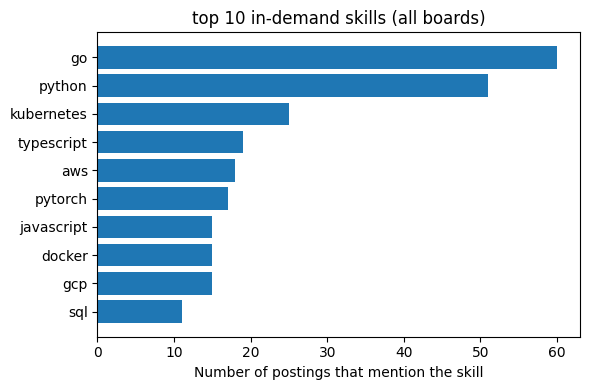

In [13]:
top_n = 10 # Number of skills we want to show
plot_df = (skill_df
           .head(top_n)
           .iloc[::-1])

plt.figure(figsize=(6,4))
plt.barh(plot_df["skill"], plot_df["count"])
plt.xlabel("Number of postings that mention the skill")
plt.title(f"top {top_n} in-demand skills (all boards)")
plt.tight_layout()
plt.show()